# Multi-class Classifier

based on [Coursera course](https://www.coursera.org/learn/convolutional-neural-networks-tensorflow/supplement/NrW0s/check-out-the-code-lab-1)

In [5]:
from tensorflow.keras import Model
from tensorflow.keras import layers
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory # 'tis a function
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from google.colab import files
import matplotlib.image as mpimg

### download and prepare dataset

In [2]:
# Download the train set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps.zip
    
# Download the test set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps-test-set.zip

--2023-01-10 10:19:06--  https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘rps.zip’

rps.zip             100%[===================>] 191.38M  15.1MB/s    in 14s     

2023-01-10 10:19:21 (13.7 MB/s) - ‘rps.zip’ saved [200682221/200682221]

--2023-01-10 10:19:21--  https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘rps-test-

In [3]:
# Extract the archive
local_zip = './rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/rps-train')
zip_ref.close()

local_zip = './rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/rps-test')
zip_ref.close()

In [4]:
base_dir = 'tmp/rps-train/rps'

rock_dir = os.path.join(base_dir, 'rock')
paper_dir = os.path.join(base_dir, 'paper')
scissors_dir = os.path.join(base_dir, 'scissors')

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
print(rock_files[:10])

paper_files = os.listdir(paper_dir)
print(paper_files[:10])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:10])

total training rock images: 840
total training paper images: 840
total training scissors images: 840
['rock03-102.png', 'rock07-k03-034.png', 'rock05ck01-036.png', 'rock05ck01-080.png', 'rock02-114.png', 'rock01-097.png', 'rock03-033.png', 'rock01-066.png', 'rock07-k03-047.png', 'rock04-095.png']
['paper04-079.png', 'paper01-077.png', 'paper02-005.png', 'paper03-038.png', 'paper06-029.png', 'paper04-011.png', 'paper05-051.png', 'paper03-104.png', 'paper06-035.png', 'paper06-003.png']
['testscissors02-077.png', 'scissors04-005.png', 'scissors02-059.png', 'testscissors03-068.png', 'testscissors03-085.png', 'testscissors02-009.png', 'scissors02-086.png', 'scissors01-054.png', 'scissors03-012.png', 'scissors02-111.png']


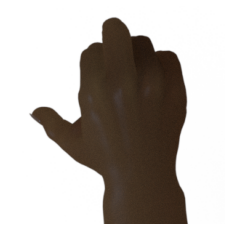

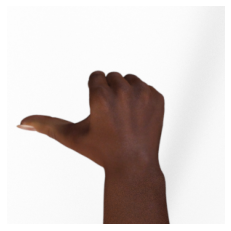

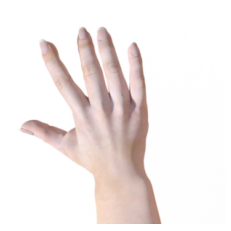

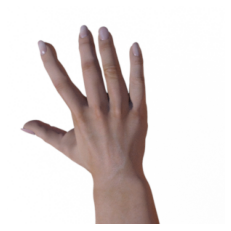

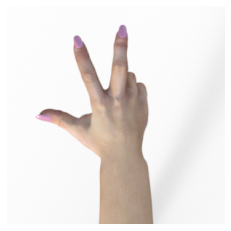

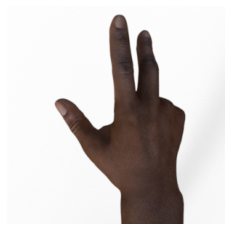

In [6]:
pic_index = 2

next_rock = [os.path.join(rock_dir, fname) 
                for fname in rock_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) 
                for fname in paper_files[pic_index-2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) 
                for fname in scissors_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

### Prepare the ImageDataGenerator

In [7]:
TRAINING_DIR = "tmp/rps-train/rps"
VALIDATION_DIR = "tmp/rps-test/rps-test-set"

In [8]:
# create generator that standardize pixel values
training_datagen = ImageDataGenerator( samplewise_center=True, samplewise_std_normalization=True,
                                   rescale = 2/255., ## ad this to limit range from -1 to 1 
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# of course we don't augment the validation dataset because it supposedly reflect outside or real life data
validation_datagen  = ImageDataGenerator(
    samplewise_center=True, samplewise_std_normalization=True,
    rescale = 2/255. ## ad this to limit range from -1 to 1
)


In [9]:
print(type(validation_datagen))

<class 'keras.preprocessing.image.ImageDataGenerator'>


we change `class_mode` when creating `DirectoryIterator` for dataset from *binary* to *categorical* 

In [10]:
train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical', ## set 'binary' if we want to categorize 2 class, else set this to categorical
  batch_size=126
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',  ## set 'binary' if we want to categorize 2 class, else set this to categorical
  batch_size=126
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [11]:
print(type(validation_generator))

<class 'keras.preprocessing.image.DirectoryIterator'>


In [14]:
labels = (train_generator.class_indices)
print(labels)
train_labels = dict((v,k) for k,v in labels.items())
train_labels

{'paper': 0, 'rock': 1, 'scissors': 2}


{0: 'paper', 1: 'rock', 2: 'scissors'}

In [15]:
labels = (validation_generator.class_indices)
print(labels)
validation_labels = dict((v,k) for k,v in labels.items())
validation_labels

{'paper': 0, 'rock': 1, 'scissors': 2}


{0: 'paper', 1: 'rock', 2: 'scissors'}

## Model and softmax

as for more than 2 class classification we use [Softmax](https://www.tensorflow.org/api_docs/python/tf/nn/softmax) as activation layer as output.

We also introduce `Dropout` to prevent overfitting

As for compile we change loss function fron `binary_crossentropy` into `categorical_crossentropy` (there are other fucntion of course)

In [50]:
def create_model(add_dropout=True):
  ## set seed so that model has same 'common ground' (it node's weight and bias are the same value on each creation)
  tf.random.set_seed(10)
  model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(name='Flatten_before_dropout'),
    tf.keras.layers.Dropout(0.5, name='Dropout_05'),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  if(not add_dropout):
    #print(model.input)
    layer_no_dropout = model.get_layer('Flatten_before_dropout')
    output_flatten = layer_no_dropout.output
    x0 = tf.keras.layers.Dense(512, activation='relu')(output_flatten)
    x1 = tf.keras.layers.Dense(3, activation='softmax')(x0)
    #print(model.input)
    model = Model(model.input, x1)
  # Set the training parameters
  model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  return model

In [51]:
model = create_model(add_dropout=True)
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_69 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 17, 17, 128)    

## Train the model and evaluate the results

In [59]:
# Constant for epochs
EPOCHS = 25

train_steps_per_epoch = train_generator.n/train_generator.batch_size
validation_steps_per_epoch = len(validation_generator.labels)/validation_generator.batch_size
train_steps_per_epoch = round(train_steps_per_epoch)
validation_steps_per_epoch = round(validation_steps_per_epoch)


print('train_steps_per_epoch:', train_steps_per_epoch )

print('validation_steps_per_epoch:', validation_steps_per_epoch )
     

train_steps_per_epoch: 20
validation_steps_per_epoch: 3


In [65]:
## note we can also do this (no need to call round up function explicitly)

print(train_generator.n//train_generator.batch_size)
print(validation_generator.n//validation_generator.batch_size)

20
2


In [60]:
# Train the model
history = model.fit(train_generator, epochs=EPOCHS, steps_per_epoch=train_steps_per_epoch, 
                    validation_data = validation_generator, verbose = 1, validation_steps=validation_steps_per_epoch)

Epoch 1/25
20/20 [==============================] - 33s 1s/step - loss: 1.5838 - accuracy: 0.3889 - val_loss: 0.7883 - val_accuracy: 0.6801
Epoch 2/25
20/20 [==============================] - 22s 1s/step - loss: 1.1252 - accuracy: 0.5258 - val_loss: 0.7678 - val_accuracy: 0.7070
Epoch 3/25
20/20 [==============================] - 22s 1s/step - loss: 0.7712 - accuracy: 0.6444 - val_loss: 0.4737 - val_accuracy: 0.6801
Epoch 4/25
20/20 [==============================] - 22s 1s/step - loss: 0.7024 - accuracy: 0.7123 - val_loss: 0.3135 - val_accuracy: 0.9355
Epoch 5/25
20/20 [==============================] - 22s 1s/step - loss: 0.5147 - accuracy: 0.7881 - val_loss: 0.1356 - val_accuracy: 0.9892
Epoch 6/25
20/20 [==============================] - 22s 1s/step - loss: 0.4380 - accuracy: 0.8302 - val_loss: 0.3204 - val_accuracy: 0.7796
Epoch 7/25
20/20 [==============================] - 22s 1s/step - loss: 0.3954 - accuracy: 0.8548 - val_loss: 0.2510 - val_accuracy: 0.8656
Epoch 8/25
20/20 [==

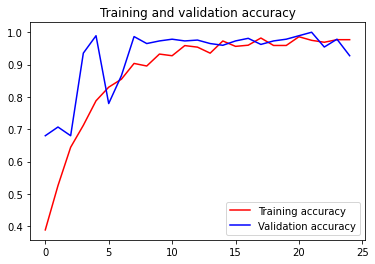

<Figure size 432x288 with 0 Axes>

In [61]:
# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

### if we don't introduce dropout

In [62]:
model = create_model(add_dropout=False)
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72_input (InputLayer  [(None, 150, 150, 3)]    0         
 )                                                               
                                                                 
 conv2d_72 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_73 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                           

In [63]:
# Train the model
history = model.fit(train_generator, epochs=EPOCHS, steps_per_epoch=train_steps_per_epoch, 
                    validation_data = validation_generator, verbose = 1, validation_steps=validation_steps_per_epoch)

Epoch 1/25
20/20 [==============================] - 23s 1s/step - loss: 2.0722 - accuracy: 0.3905 - val_loss: 1.0476 - val_accuracy: 0.3629
Epoch 2/25
20/20 [==============================] - 22s 1s/step - loss: 0.9864 - accuracy: 0.5313 - val_loss: 0.6567 - val_accuracy: 0.8333
Epoch 3/25
20/20 [==============================] - 22s 1s/step - loss: 0.8641 - accuracy: 0.6425 - val_loss: 0.4316 - val_accuracy: 0.7903
Epoch 4/25
20/20 [==============================] - 22s 1s/step - loss: 0.6657 - accuracy: 0.7214 - val_loss: 0.2353 - val_accuracy: 0.9785
Epoch 5/25
20/20 [==============================] - 22s 1s/step - loss: 0.5308 - accuracy: 0.7881 - val_loss: 0.4464 - val_accuracy: 0.7124
Epoch 6/25
20/20 [==============================] - 22s 1s/step - loss: 0.3923 - accuracy: 0.8389 - val_loss: 0.6490 - val_accuracy: 0.6989
Epoch 7/25
20/20 [==============================] - 22s 1s/step - loss: 0.3308 - accuracy: 0.8778 - val_loss: 0.0496 - val_accuracy: 0.9866
Epoch 8/25
20/20 [==

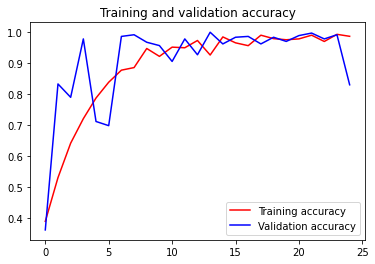

<Figure size 432x288 with 0 Axes>

In [64]:
# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

other dataset archive  
https://archive.ics.uci.edu/ml/datasets.php